# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solve challenging problems in computer vision. Specifically, you'll use a network trained on [ImageNet](http://www.image-net.org/). ImageNet is a massive dataset with over 1 million labeled images in 1,000 categories.

These pre-trained models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called **Transfer Learning**. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With [TensorFlow Hub](https://www.tensorflow.org/hub) you can download these pre-trained networks and use them in your applications.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.9.1
	• tf.keras version: 2.9.0
	• Running on GPU


## Load the Dataset

In [5]:
train_split = 60
test_val_split = 20

#splits = tfds.Split.ALL.subsplit([60,20, 20])
splits = ['train[0%:60%]', 'train[60%:80%]', 'train[80%:100%]']

(training_set, validation_set, test_set), dataset_info = tfds.load('cats_vs_dogs', split=splits, as_supervised=True, with_info=True)

## Explore the Dataset

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~\\tensorflow_datasets\\cats_vs_dogs\\4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon 

In [7]:
num_classes = dataset_info.features['label'].num_classes
total_num_examples = dataset_info.splits['train'].num_examples

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images'.format(total_num_examples))

The Dataset has a total of:
• 2 classes
• 23,262 images


As a technical note, if the total number of examples in your dataset is not a multiple of 100 (*i.e.* if `total_num_examples % 100 != 0`), then TensorFlow may not evenly distribute the data among subsplits. As we can see, our dataset has `23,262` examples, which is not a multiple of 100. Therefore, in this particular case, we should expect that our data would not be evenly distributed among the subsplits that we created. This means that even though we set our `split` to allocate 60\% of the data to the training set, 20\% of the data to the validation set, and 20\% of the data to the test set, the actual number of images in each set may vary from these percentages. It is important to note, that these small differences will not affect our training process. We didn't have this issue before when we worked the MNIST and Fashion-MNIST datasets because both of these datasets had 70,000 examples. Since 70,000 is a multiple of 100, then the data was evenly distributed in both of those cases.

In [8]:
class_names = ['cat', 'dog']

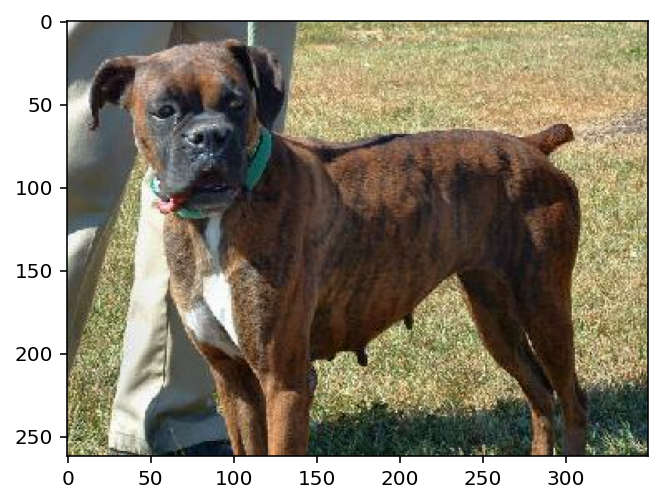

The label of this image is: 1
The class name of this image is: dog


In [9]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

## Create Pipeline

The pre-trained model we are going to use requires that the input images have color values in the range `[0,1]` and a size of `(224, 224)`. We will therefore have to normalize the pixel values of our images and resize them to the appropriate size. We can normalize our pixel values in the usual way by dividing the original pixel values by `255` and to resize our images we can use the `tf.image.resize()` function.

In [10]:
batch_size = 32
image_size = 224

num_training_examples = (total_num_examples * train_split) // 100

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

## Transfer Learning with TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is an online repository of pre-trained models. In addition to complete pre-trained models, TensorFlow Hub also contains models without the last classification layer. These models can be used to perform transfer learning by adding a classification layer that suits the number of classes in your particular dataset. You can take a look at all the models available for TensorFlow 2.0 in [TensorFlow Hub](https://tfhub.dev/s?q=tf2-preview).

In this notebook, we will use a network trained on the ImageNet dataset called MobileNet. MobileNet is a state-of-the-art convolutional neural network developed by Google. Convolutional neural networks are out of the scope of this course, but if you want to learn more about them, you can take a look at this [video](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

In the cell below we download the pre-trained MobileNet model without the final classification layer from TensorFlow Hub using the `hub.KerasLayer(URL)` function. This function downloads the desired model form the given TensorFlow Hub `URL` and wraps it in a Keras layer so that we can integrate it in a `tf.keras` Sequential model later. Since this will be the first layer of our Sequential model, we need to specify the `input_shape` parameter. The shape of our input tensor must match the size of the images MobileNet was trained on, namely `(224,224,3)`. 

Our pre-trained model will be responsible for extracting the features of our images, we will therefore call this part of our model the `feature_extractor`.

In [1]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

NameError: name 'hub' is not defined

It is important that we freeze the weights and biases in our pre-trained model so that we don't modify them during training. We can do this by setting the parameters of our model to non-trainable, as shown in the code below.

In [ ]:
feature_extractor.trainable = False

## Build the Model

We will now create a `tf.keras` Sequential model with our `feature_extractor` and a new classification layer. Since our dataset only has 2 classes (cat and dog) we create an output layer with only 2 units. 

In [ ]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model Using a GPU

With our model built, we now need to train the new classification layer, but this time we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use a GPU to do the calculations. On a GPU, linear algebra computations are done in parallel, leading to 100x increased training speeds. TensorFlow will transparently run on a single GPU without requiring that we make changes to our code. With TensorFlow, it's also possible to train on multiple GPUs, further decreasing training time, but this requires that we make changes to our code to incorporate [distributed training](https://www.tensorflow.org/guide/distributed_training). 

We can use the `tf.test.is_gpu_available()` function to confirm that TensorFlow is using the GPU.

In [ ]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


TensorFlow uses different string identifiers for CPUs and GPUs. For example, TensorFlow will use the identifier:

```python
'/CPU:0'
```
for the CPU of your machine; and it will use the identifier:

```python
'/GPU:0'
```
for the first GPU of your machine that is visible to TensorFlow. If your system has both devices, `/CPU:0` and `/GPU:0`, by default the GPU devices will be given priority when preforming TensorFlow operations (given that the TensorFlow operations have both CPU and GPU implementations). For example, the TensorFlow `tf.matmul` operation has both CPU and GPU kernels, therefore, the `/GPU:0` device will be selected to run `tf.matmul` unless you explicitly request running it on another device.

### Manual Device Placement

If you would like a particular TensorFlow operation to run on the device of your choice, instead of what's automatically selected for you by default, you can use:

```python
# Place tensors on the CPU
with tf.device('/CPU:0'):
    perform operations
```

to have operations run on the CPU; and you can use:
  
```python
# Place tensors on the GPU
with tf.device('/GPU:0'):
    perform operations
```

to have operations run on the GPU.

#### Example

Let's assume we have a system that has both devices, `/CPU:0` and `/GPU:0`. What will happen if we run the code below?

```python
# Place tensors on the CPU
with tf.device('/CPU:0'):
    a = tf.random.normal(...)
    b = tf.random.normal(...)

c = tf.matmul(a, b)
```

The above code will create both `a` and `b` using the CPU because we manually assigned those statements to the 
`/CPU:0` device using the `with tf.device('/CPU:0')` code block. However, since the statement `c = tf.matmul(a, b)` is NOT inside the `with tf.device('/CPU:0')` code block, then TensorFlow will run the `tf.matmul` operation on the `/GPU:0` device. TensorFlow will automatically copy tensors between devices if required.

In the code below, we will multiply matrices of increasing size using both the CPU and GPU so you can see the difference in execution time. You will see, that as the size of the matrices increase, the execution time on the CPU increases rapidly, but on the GPU it stays constant.

Performing Calculations. Please Wait... 100% Complete

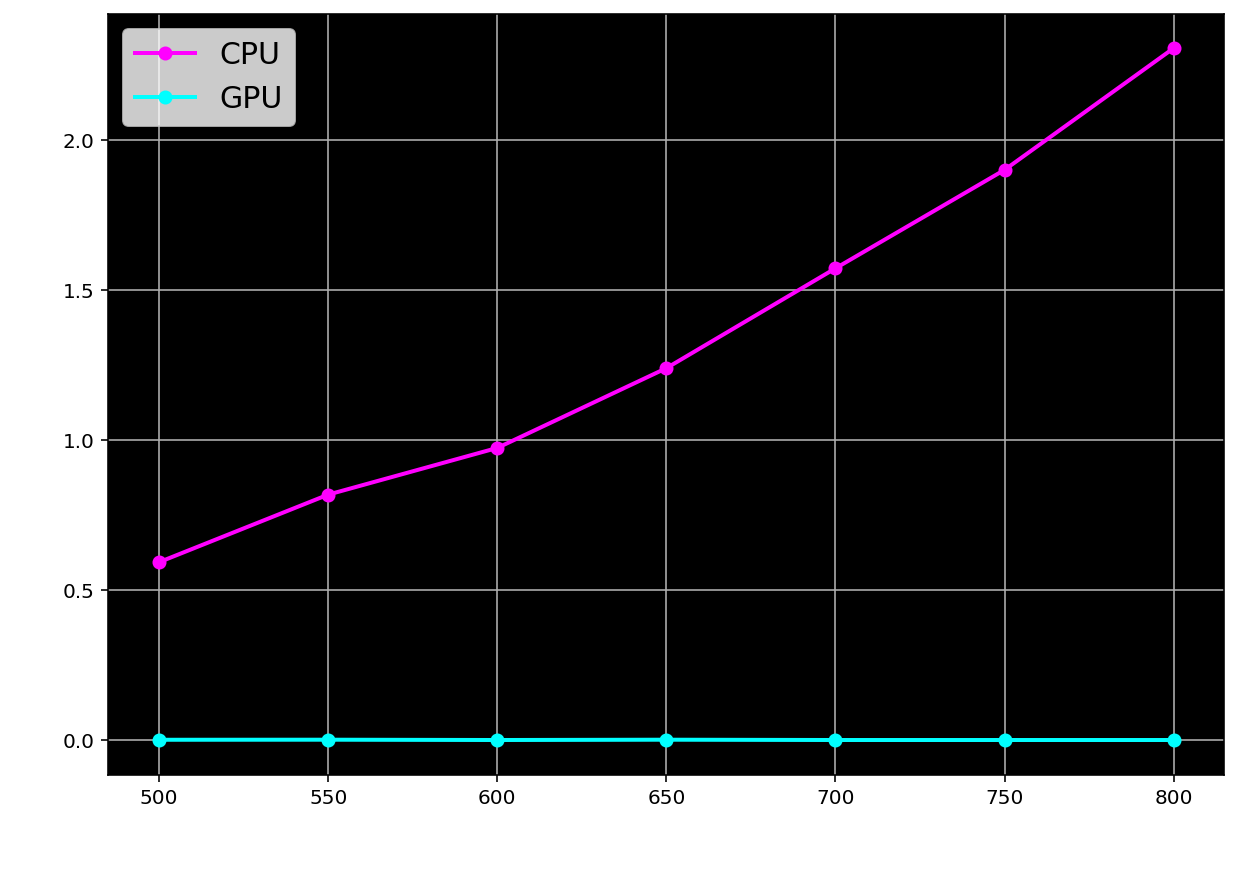

In [ ]:
def plot_times(max_size = 650):
    device_times = {'/GPU:0':[], '/CPU:0':[]}
    matrix_sizes = range(450, max_size, 50)
    len_matrix = len(matrix_sizes)

    for i, size in enumerate(matrix_sizes):
        for device_name in device_times.keys():
            with tf.device(device_name):
                m1 = tf.random.uniform(shape=(size,size), dtype=tf.float16)
                m2 = tf.random.uniform(shape=(size,size), dtype=tf.float16)
                start_time = time.time()
                dot_operation = tf.matmul(m2, m1)
                time_taken = time.time() - start_time
                
                if i > 0:
                    device_times[device_name].append(time_taken)
                    
        percent_complete = (i + 1) / len_matrix
        print('\rPerforming Calculations. Please Wait... {:.0%} Complete'.format(percent_complete), end = '')
    
    matrix_sizes = matrix_sizes[1:]
    
    plt.figure(figsize=(10,7))
    
    plt.plot(matrix_sizes, device_times['/CPU:0'], 'o-', color='magenta', linewidth = 2, label = 'CPU')
    plt.plot(matrix_sizes, device_times['/GPU:0'], 'o-', color='cyan', linewidth = 2, label='GPU')
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
    plt.ylabel('Time (s)', color='white', fontsize = 20)
    plt.xlabel('Matrix size',  color='white', fontsize = 20)
    plt.legend(prop={'size': 15})
    plt.show()
    
plot_times(850)

From here, I'll let you finish training the model. The process is the same as before except that now your model will automatically run on the GPU. You should get better than 95% accuracy easily.

>**Exercise:** Train the `model` we created above to classify the cat and dog images in our dataset. Because we are using a pre-trained model, you will only need to train the model for a few epochs to get a high accuracy.

In [ ]:
## Solution
tf.device('/CPU:0')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_batches, epochs=5)

Epoch 1/5


: 

: 

# Check Predictions

In [ ]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')